KU)4AMP01 peptide in water
======================


## ``Gromacs_py`` simulation

Here is an example of a short simulation of the KU04AMP01 peptide (`ku04amp01`, also  `protein`) in water using AMBER force-field model. The protein is unfolded and is a 'linear' peptide. The objective it to see how it folds under dynamical evolution under cell conditions.


Finally, nine successive steps are used:

1. Load the protein. 
   
2. In-complex creation of Protein Topology using ``GmxSys.add_top()``, followed by boxing and solvation/neutralization.
   
3. Boxing of complex.
   
4. Solvate complex and add ions.

5. Minimisation of the structure using ``GmxSys.em_2_steps()``.

6. Equilibration of the system using ``GmxSys.em_equi_three_step_iter_error()``.

7. Production run using ``GmxSys.production()``.
   
8.  Post-processing using `GmxSys.convert_trj().`

### Import

In [1]:
import sys
import os
import shutil

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## To use `gromacs_py` in a project

In [2]:
from gromacs_py import gmx

## Simulation setup

- Define a few variables for you simulation, like:
  
    1. simulation output folders
    2. ionic concentration
    3. number of minimisation steps
    4. equilibration and production time

### Regarding equilibriation time:
The following variables define the sim times (relative units) for each stage of the three-stage equilibriation process. Check notes below for details:

1. `HA_time`
2. `CA_time`
3. `CA_LOW_time` 


In [3]:
DATA_OUT = 'ku04amp02_linear'

# System Setup
vsite='none'
sys_top_folder = os.path.join(DATA_OUT, 'sys_top')
#ignore_hydrogen = {'ignh': None}

# Energy Minimisation
em_folder = os.path.join(DATA_OUT, 'em')
em_sys_folder = os.path.join(DATA_OUT, 'sys_em')
em_step_number = 10000
emtol = 10.0  	# Stop minimization when the maximum force < 10 J/mol
emstep  = 0.01      # Energy step size


# Equillibration
equi_folder = os.path.join(DATA_OUT, 'sys_equi')
HA_time = 0.5
CA_time = 1.0
CA_LOW_time = 4.0

dt_HA = 0.001
dt = 0.002

HA_step = 1000 * HA_time / dt_HA
CA_step = 1000 * CA_time / dt
CA_LOW_step = 1000 * CA_LOW_time / dt

# Production
os.makedirs(DATA_OUT, exist_ok = True)
prod_folder = os.path.join(DATA_OUT, 'sys_prod')
prod_time = 50.0

prod_step = 1000 * prod_time / dt

## Create the `GmxSys` object

Load protein information only from docked PDB file on disk

In [4]:
%%script true

pdb_file = "KU04AMP02.pdb"
sys_name = "ku04amp02_linear"
complex_sys = gmx.GmxSys(name=sys_name, coor_file=pdb_file)

## Create topology and stuff

1. Topology creation involves using `pdb2gmx` via the `prepare_top()` function.
2. Create box

**Note:** I had to explicitly center the peptide inside the box, or the peptide keeps going out during boxing, causing PBC to fragment the peptide during EM.

In [5]:
%%script true
complex_sys.prepare_top(out_folder=DATA_OUT, ff='amber99sb-ildn', ph=7.0)

In [6]:
%%script true
complex_sys.display()

In [7]:
%%script true
complex_sys.create_box(dist=1.0, box_type="dodecahedron", check_file_out=True)

In [8]:
%%script true
complex_sys.solvate_add_ions(out_folder=DATA_OUT, name=sys_name,create_box_flag=False, maxwarn=4)
complex_sys.display()

## Energy minimisation

Set parallelization and GPU options here. Change them later, if needed.

In [9]:
%%script true
#Parallelization
nthreads = int(os.environ.get('PBS_NCPUS', '16'))

#Set Parallelization
complex_sys.nt = nthreads
#complex_sys.ntmpi = 1
complex_sys.gpu_id = '0'

complex_sys.em_2_steps(out_folder=em_folder,
        no_constr_nsteps=em_step_number,
        constr_nsteps=em_step_number,
        posres="",
        create_box_flag=False, emtol=emtol, emstep=emstep)

## re-centering

Explicitly center the system in a box, otherwise the protein fragments due to PBC.

In [10]:
%%script true
complex_sys.center_mol_box()

## Plot energy:

In [11]:
%%script true
ener_pd_1 = complex_sys.sys_history[-1].get_ener(selection_list=['Potential'])
ener_pd_2 = complex_sys.get_ener(selection_list=['Potential'])

ener_pd_1['label'] = 'no bond constr'
ener_pd_2['label'] = 'bond constr'

ener_pd = pd.concat([ener_pd_1, ener_pd_2])

ener_pd['Time (ps)'] = np.arange(len(ener_pd))

In [12]:
%%script true
ax = sns.lineplot(x="Time (ps)", y="Potential",
        hue="label",
        data=ener_pd)
ax.set_xlabel('step')
ax.set_ylabel('energy (KJ/mol)')
plt.grid()

In [13]:
%%script true
complex_sys.display()

In [14]:
%%script true
import pickle, datetime
chkpt_fname='checkpoint.em_' + datetime.date.today().strftime("%Y%m%d") + ".pycpt"
with open(chkpt_fname, 'wb') as py_cpt:
    pickle.dump(complex_sys, py_cpt)

## From here, run in cluster
### System minimisation and equilibration

Based on `gromacs_py` docs, this is a 3-stage equilibriation process. 

All three steps seem to be NPT with berendsen coupling and v-rescale for temp coupling. Each step just has different restraints. This does not seem so bad: closer to lab conditions.

Since the statistical ensemble is pretty much always NPT, this is different from the Lemkul-lysozyme tutorial at [MDTutorials](http://www.mdtutorials.com/gmx/lysozyme/).

**Note:** 
1. Had to run this on cluster at least. Too slow even in ofc workstn.
2. Temperature coupling groups have to be set properly. See [mdtutorials](http://www.mdtutorials.com/gmx/complex/06_equil.html) and [gromacs-py manual](https://gromacs-py.readthedocs.io/en/latest/notebook/01_dna_ligand_ambertools.html#System-equilibration)
3. Ligand name is `PYC` as seen in the index file by visual inspection.

In [15]:
#%%script true
import pickle, datetime
chkpt_fname='checkpoint.em_20250630.pycpt'

with open(chkpt_fname, 'rb') as py_cpt:
    complex_sys = pickle.load(py_cpt)

In [16]:
#%%script true
#Parallelization
nthreads = int(os.environ.get('PBS_NCPUS', '16'))

#Set Parallelization
complex_sys.nt = nthreads
#complex_sys.ntmpi = 1
complex_sys.gpu_id = '0'

complex_sys.em_equi_three_step_iter_error(out_folder=equi_folder,
        no_constr_nsteps=em_step_number,
        constr_nsteps=em_step_number,
        nsteps_HA=HA_step,  
        nsteps_CA=CA_step,
        nsteps_CA_LOW=CA_LOW_step,
        dt=dt, dt_HA=dt_HA,
        tc_grps='Protein Water_and_ions',
        tau_t= '0.1 0.1',
        ref_t= '310 310',
        vsite=vsite, maxwarn=10, iter_num=1)

gmx grompp -f Init_em_ku04amp02_linear.mdp -c ../../em/ku04amp02_linear_compact.pdb -r ../../em/ku04amp02_linear_compact.pdb -p ../../ku04amp02_linear_water_ion.top -po out_Init_em_ku04amp02_linear.mdp -o Init_em_ku04amp02_linear.tpr -maxwarn 10 -n ../../em/ku04amp02_linear.ndx


gmx mdrun -s Init_em_ku04amp02_linear.tpr -deffnm Init_em_ku04amp02_linear -nt 32 -ntmpi 0 -nsteps -2 -nocopyright -gpu_id 0


  0%|          | 0/10000 [00:00<?, ?it/s]

gmx grompp -f ku04amp02_linear.mdp -c Init_em_ku04amp02_linear.gro -r Init_em_ku04amp02_linear.gro -p ../../ku04amp02_linear_water_ion.top -po out_ku04amp02_linear.mdp -o ku04amp02_linear.tpr -maxwarn 10 -n ../../em/ku04amp02_linear.ndx


gmx mdrun -s ku04amp02_linear.tpr -deffnm ku04amp02_linear -nt 32 -ntmpi 0 -nsteps -2 -nocopyright -gpu_id 0


  0%|          | 0/10000 [00:00<?, ?it/s]

gmx trjconv -f ku04amp02_linear/sys_equi/sys_em/ku04amp02_linear.gro -o ku04amp02_linear/sys_equi/sys_em/ku04amp02_linear_compact.pdb -s ku04amp02_linear/sys_equi/sys_em/ku04amp02_linear.tpr -ur compact -pbc mol -n ku04amp02_linear/em/ku04amp02_linear.ndx


gmx grompp -f equi_HA_ku04amp02_linear.mdp -c ../../sys_em/ku04amp02_linear_compact.pdb -r ../../sys_em/ku04amp02_linear_compact.pdb -p ../../../ku04amp02_linear_water_ion.top -po out_equi_HA_ku04amp02_linear.mdp -o equi_HA_ku04amp02_linear.tpr -maxwarn 10 -n ../../../em/ku04amp02_linear.ndx


gmx mdrun -s equi_HA_ku04amp02_linear.tpr -deffnm equi_HA_ku04amp02_linear -nt 32 -ntmpi 0 -nsteps -2 -nocopyright -gpu_id 0


  0%|          | 0/500000 [00:00<?, ?it/s]

gmx grompp -f equi_CA_ku04amp02_linear.mdp -c ../00_equi_HA/equi_HA_ku04amp02_linear.gro -r ../../sys_em/ku04amp02_linear_compact.pdb -p ../../../ku04amp02_linear_water_ion.top -po out_equi_CA_ku04amp02_linear.mdp -o equi_CA_ku04amp02_linear.tpr -maxwarn 10 -n ../../../em/ku04amp02_linear.ndx


gmx mdrun -s equi_CA_ku04amp02_linear.tpr -deffnm equi_CA_ku04amp02_linear -nt 32 -ntmpi 0 -nsteps -2 -nocopyright -gpu_id 0


  0%|          | 0/500000 [00:00<?, ?it/s]

gmx grompp -f equi_CA_LOW_ku04amp02_linear.mdp -c ../01_equi_CA/equi_CA_ku04amp02_linear.gro -r ../../sys_em/ku04amp02_linear_compact.pdb -p ../../../ku04amp02_linear_water_ion.top -po out_equi_CA_LOW_ku04amp02_linear.mdp -o equi_CA_LOW_ku04amp02_linear.tpr -maxwarn 10 -n ../../../em/ku04amp02_linear.ndx


gmx mdrun -s equi_CA_LOW_ku04amp02_linear.tpr -deffnm equi_CA_LOW_ku04amp02_linear -nt 32 -ntmpi 0 -nsteps -2 -nocopyright -gpu_id 0


  0%|          | 0/2000000 [00:00<?, ?it/s]

In [17]:
#%%script true
import pickle, datetime
chkpt_fname='checkpoint.equi_' + datetime.date.today().strftime("%Y%m%d") + ".pycpt"
with open(chkpt_fname, 'wb') as py_cpt:
    pickle.dump(complex_sys, py_cpt)

### Plot Equilibriation

Since the statistical ensemble is pretty much always NPT, this is different from the Lemkul-lysozyme tutorial at [MDTutorials](http://www.mdtutorials.com/gmx/lysozyme/). So we need to see Volume as well as Pressure, temperature, and density.

In [18]:
%%script true
import pickle, datetime
chkpt_fname='checkpoint.equi_20250307.pycpt'

with open(chkpt_fname, 'rb') as py_cpt:
    complex_sys = pickle.load(py_cpt)

In [19]:
#%%script true
quantities = ["Temperature", "Pressure", "Volume", "Density"]
units = ["$K$", "$bar$", "$A^3$", "$kg/m^3$"]

pd_1 = complex_sys.sys_history[-2].get_ener(selection_list=quantities)
pd_2 = complex_sys.sys_history[-1].get_ener(selection_list=quantities)
pd_3 = complex_sys.get_ener(selection_list=quantities)

pd_1['label'] = 'HA_constr'
pd_2['label'] = 'CA_constr'
pd_2['Time (ps)'] = pd_2['Time (ps)'] + pd_1['Time (ps)'].max()
pd_3['label'] = 'CA_LOW_constr'
pd_3['Time (ps)'] = pd_3['Time (ps)'] + pd_2['Time (ps)'].max()

display(pd.concat([pd_1, pd_2, pd_3]))

gmx energy -f ku04amp02_linear/sys_equi/sys_equi/00_equi_HA/equi_HA_ku04amp02_linear.edr -o tmp_edr.xvg
gmx energy -f ku04amp02_linear/sys_equi/sys_equi/01_equi_CA/equi_CA_ku04amp02_linear.edr -o tmp_edr.xvg
gmx energy -f ku04amp02_linear/sys_equi/sys_equi/02_equi_CA_LOW/equi_CA_LOW_ku04amp02_linear.edr -o tmp_edr.xvg


,Time (ps),Temperature,Pressure,Volume,Density,label
0,0.0,0.009125,-4621.527832,543.767456,976.105591,HA_constr
1,5.0,309.358124,-106.673683,537.599426,987.304688,HA_constr
2,10.0,310.410278,33.770527,537.119080,988.187683,HA_constr
3,15.0,310.135345,-76.217003,537.271179,987.907898,HA_constr
4,20.0,309.095978,118.482094,537.211365,988.017883,HA_constr
...,...,...,...,...,...,...
396,5460.0,310.026459,-59.566463,538.421875,985.796570,CA_LOW_constr
397,5470.0,308.895538,-55.329380,537.605103,987.294312,CA_LOW_constr
398,5480.0,308.169952,13.213429,535.585693,991.016846,CA_LOW_constr
399,5490.0,311.562195,-15.436727,538.332458,985.960327,CA_LOW_constr


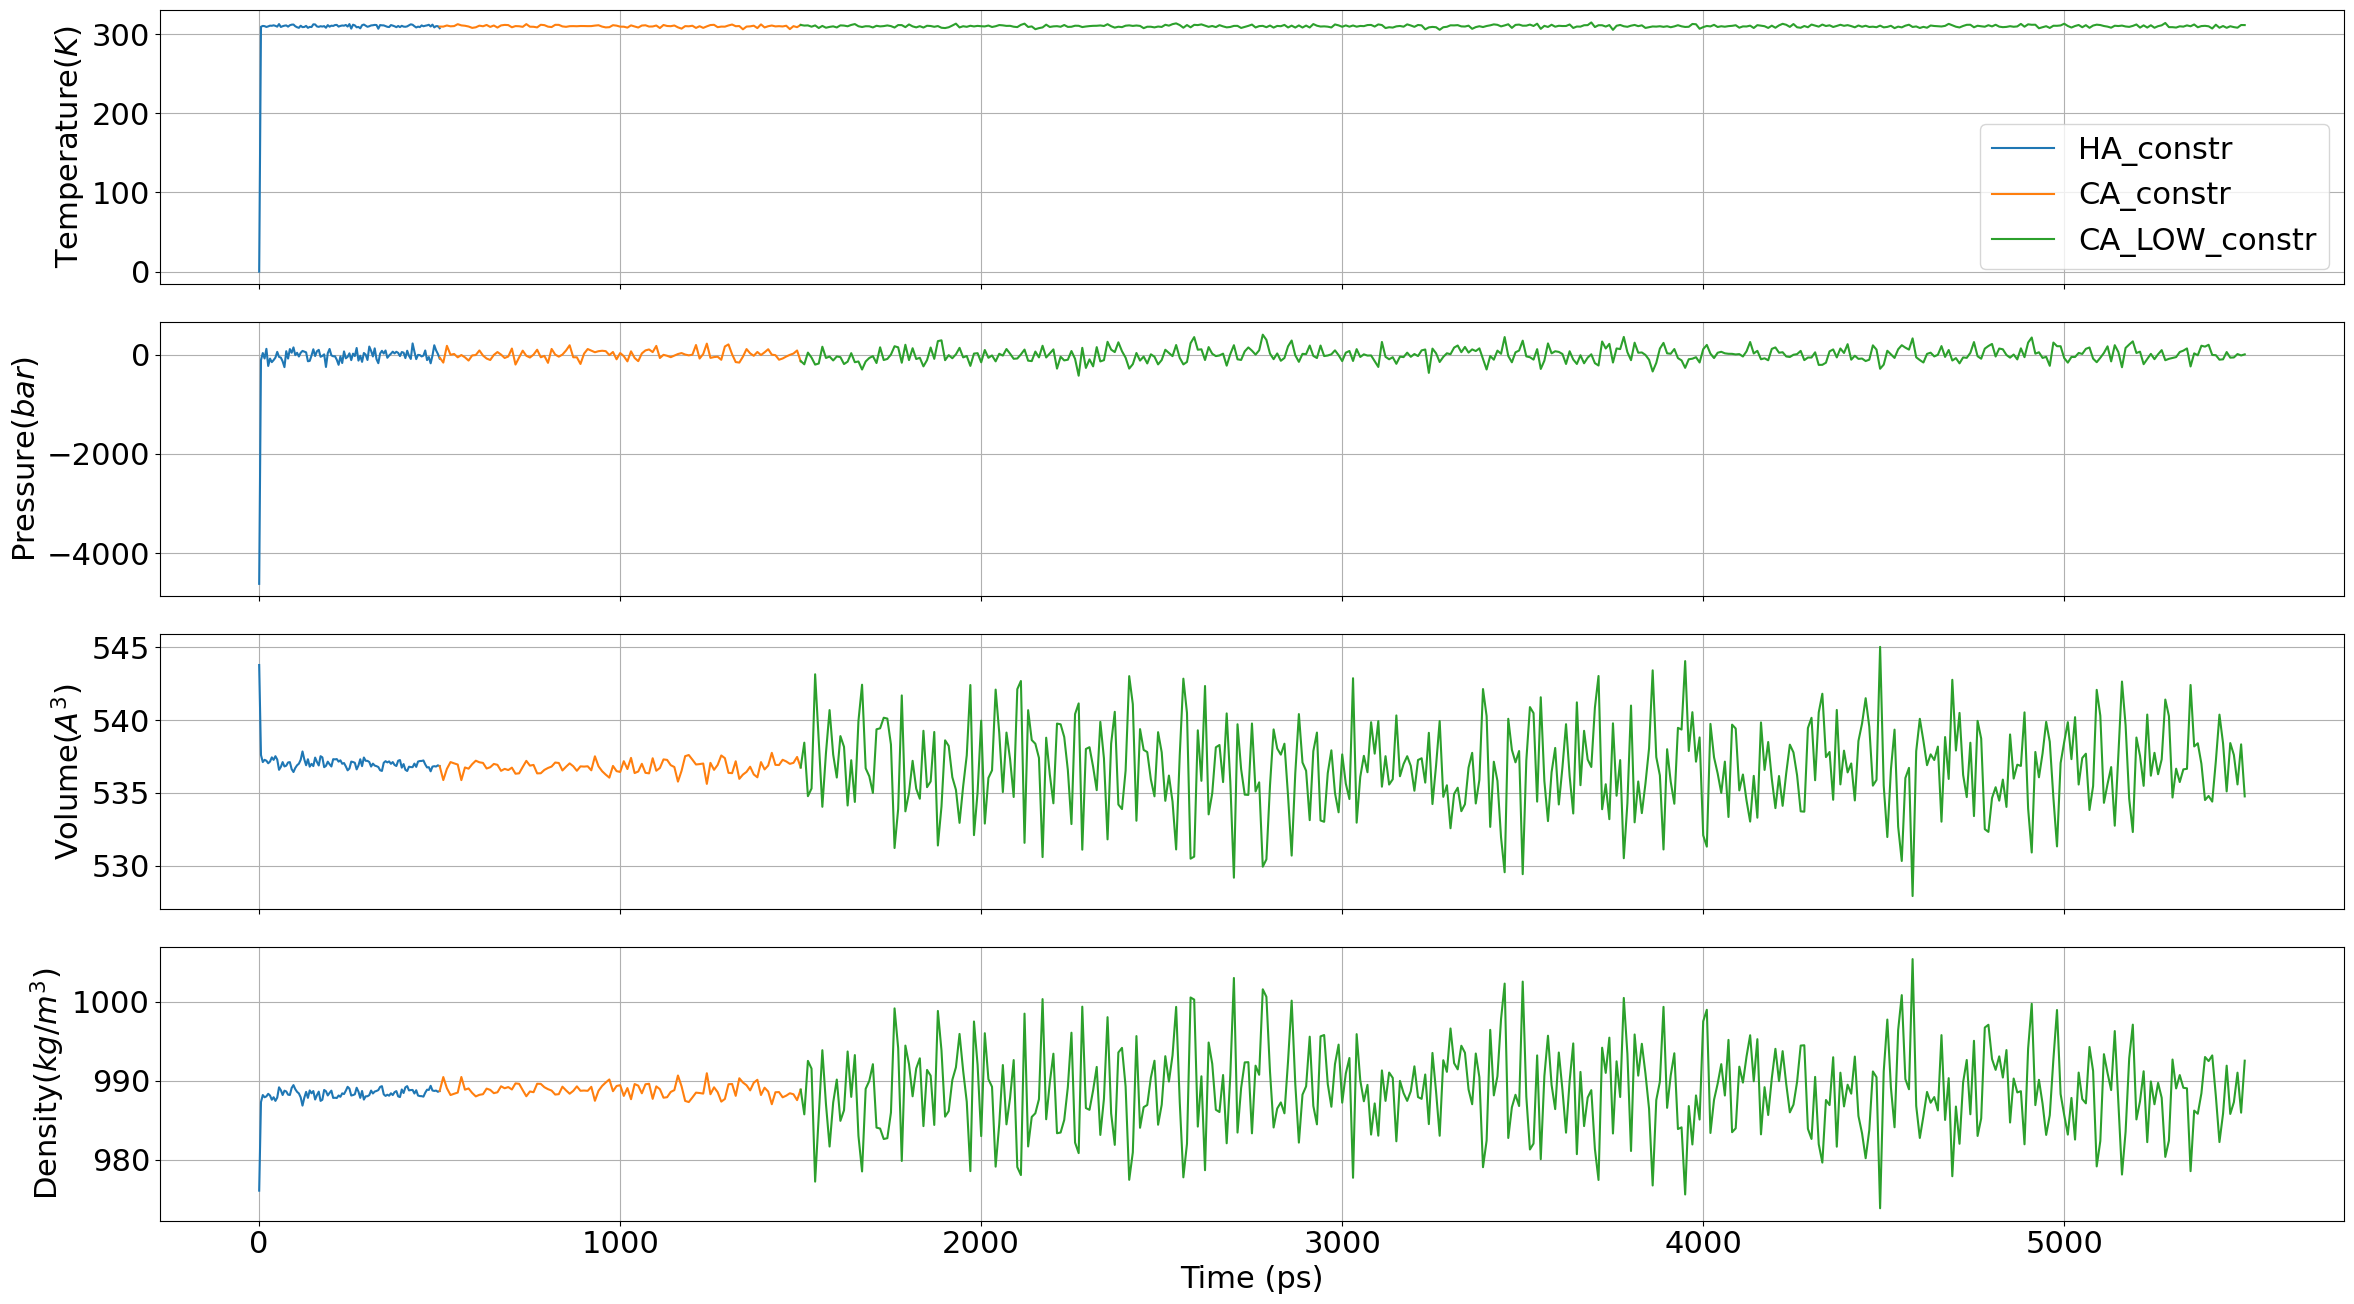

In [20]:
#%%script true
plt.rcParams.update({'font.size': 22})

fig, axs = plt.subplots(4, 1, figsize=(24,13.5), sharex=True, tight_layout=True)

for ax, quantity, unit in zip(axs, quantities, units):
    for df in (pd_1, pd_2, pd_3):
        ax.plot(df["Time (ps)"], df[quantity], label=str(df['label'][0]))
        ax.set_ylabel(quantity + "(" + unit + ")")
        ax.grid()

axs[0].legend()
axs[-1].set_xlabel("Time (ps)");

Looks okay to me. Fluctuations are high at the end because CA constraints are low, but there is a well-defined average.

### Plot RMSD


In [21]:
#%%script true
# Define reference structure for RMSD calculation
ref_sys =  complex_sys.sys_history[1]
struct="Protein"

rmsd_pd_1 = complex_sys.sys_history[-2].get_rmsd([struct, struct], ref_sys=ref_sys)
rmsd_pd_2 = complex_sys.sys_history[-1].get_rmsd([struct, struct], ref_sys=ref_sys)
rmsd_pd_3 = complex_sys.get_rmsd([struct, struct], ref_sys=ref_sys)


rmsd_pd_1['label'] = 'HA_constr'
rmsd_pd_2['label'] = 'CA_constr'
rmsd_pd_2['time'] = rmsd_pd_2['time'] + rmsd_pd_1['time'].max()
rmsd_pd_3['label'] = 'CA_LOW_constr'
rmsd_pd_3['time'] = rmsd_pd_3['time'] + rmsd_pd_2['time'].max()

display(pd.concat([rmsd_pd_1, rmsd_pd_2, rmsd_pd_3]))


gmx rms -s ku04amp02_linear/em/Init_em_ku04amp02_linear.tpr -f ku04amp02_linear/sys_equi/sys_equi/00_equi_HA/equi_HA_ku04amp02_linear.xtc -n ku04amp02_linear/em/ku04amp02_linear.ndx -o tmp_rmsd.xvg -fit rot+trans -ng 1 -pbc no


gmx rms -s ku04amp02_linear/em/Init_em_ku04amp02_linear.tpr -f ku04amp02_linear/sys_equi/sys_equi/01_equi_CA/equi_CA_ku04amp02_linear.xtc -n ku04amp02_linear/em/ku04amp02_linear.ndx -o tmp_rmsd.xvg -fit rot+trans -ng 1 -pbc no


gmx rms -s ku04amp02_linear/em/Init_em_ku04amp02_linear.tpr -f ku04amp02_linear/sys_equi/sys_equi/02_equi_CA_LOW/equi_CA_LOW_ku04amp02_linear.xtc -n ku04amp02_linear/em/ku04amp02_linear.ndx -o tmp_rmsd.xvg -fit rot+trans -ng 1 -pbc no


,time,Protein,label
0,0.0,2.387559,HA_constr
1,5.0,2.379639,HA_constr
2,10.0,2.388146,HA_constr
3,15.0,2.373478,HA_constr
4,20.0,2.381512,HA_constr
...,...,...,...
396,5460.0,2.377967,CA_LOW_constr
397,5470.0,2.329828,CA_LOW_constr
398,5480.0,2.391439,CA_LOW_constr
399,5490.0,2.370366,CA_LOW_constr


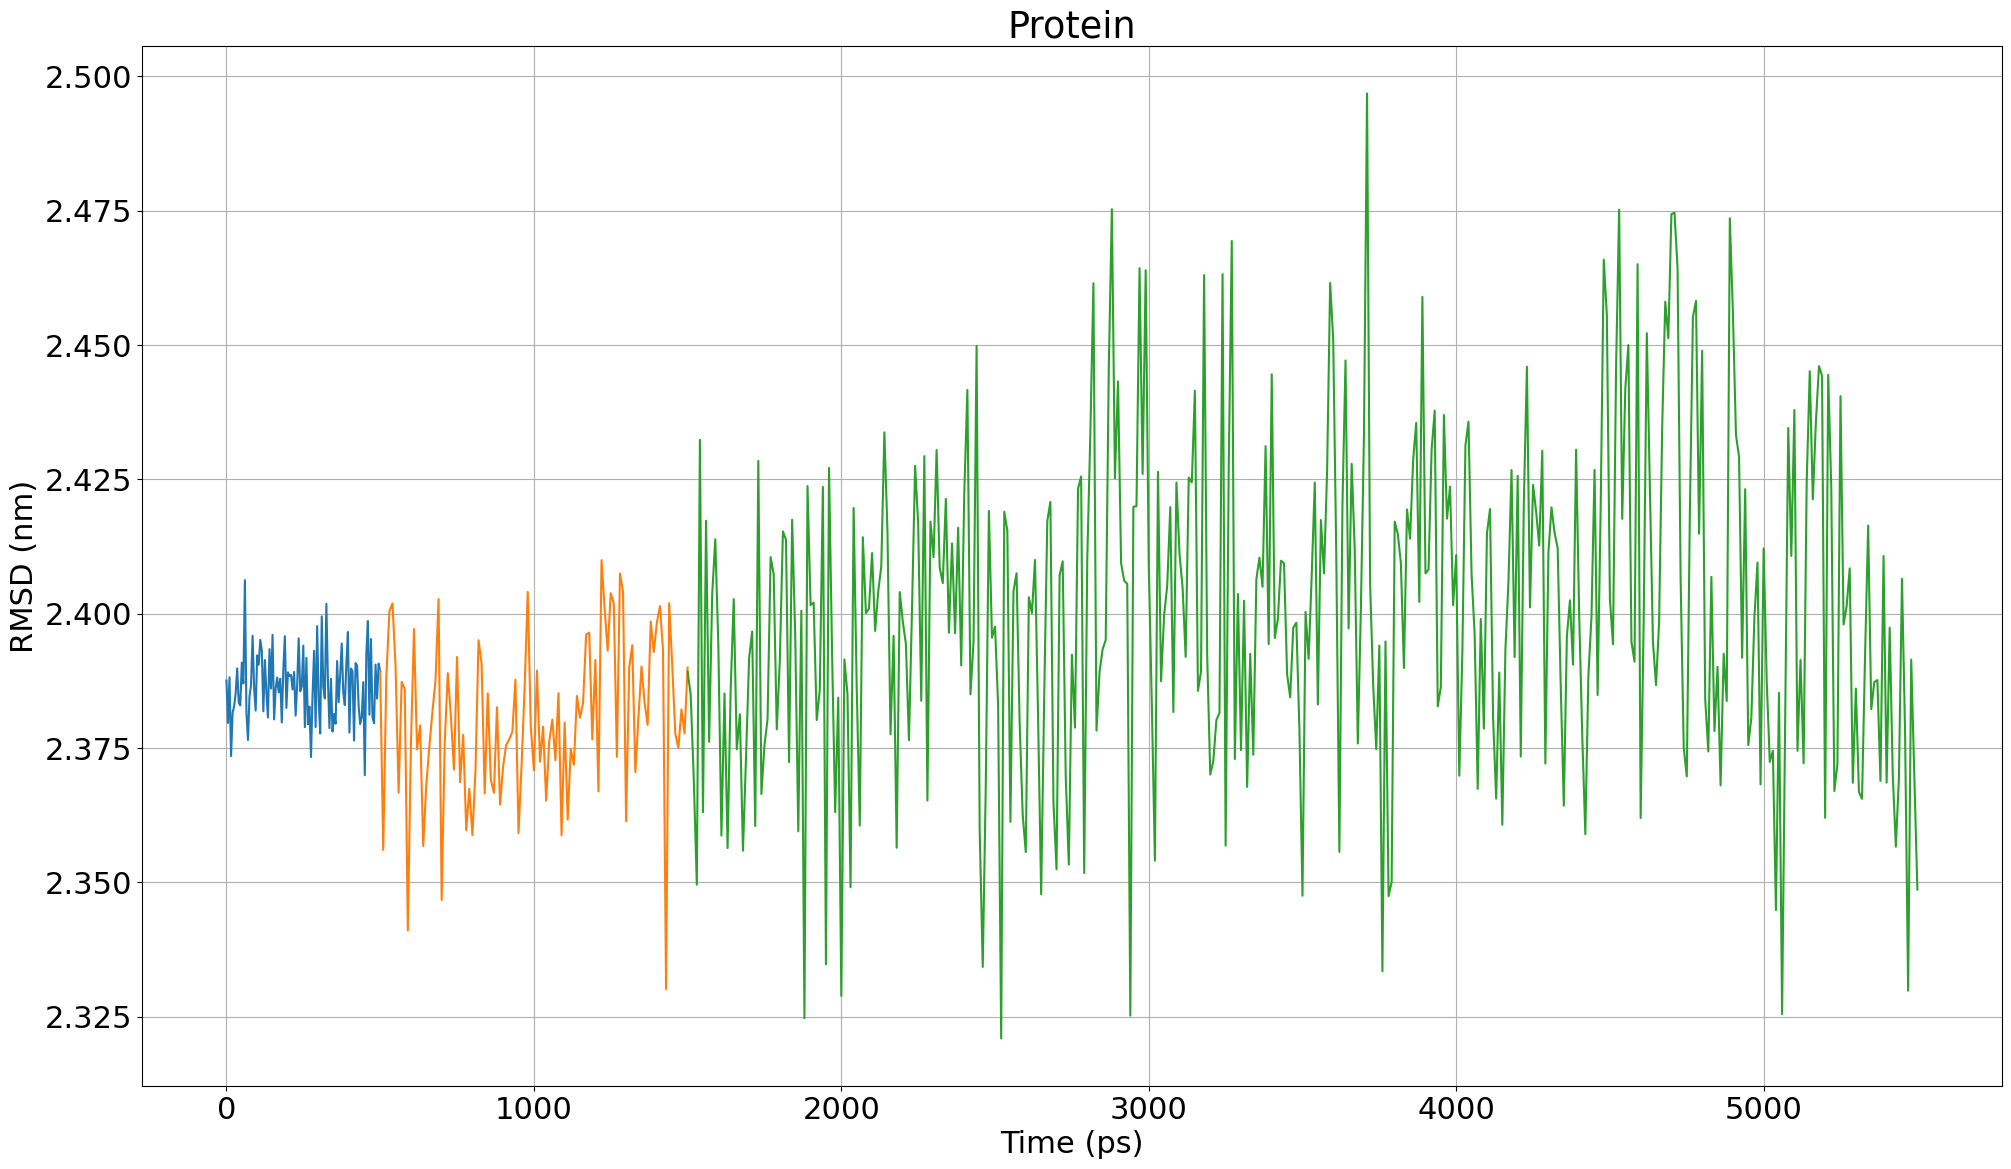

In [22]:
#%%script true
fig, ax = plt.subplots(1, 1, figsize=(24,13.5))

for df in (rmsd_pd_1, rmsd_pd_2, rmsd_pd_3):
        ax.plot(df["time"], df["Protein"], label=str(df['label'][0]))
        
ax.set_title(struct)
ax.set_ylabel('RMSD (nm)')
ax.set_xlabel('Time (ps)')
plt.grid()

### Prepare Equilibration Trajectories for viewing

Center the peptide on all of them, then fit rotation and translation for smoother visualization.

In [23]:
#%%script true
complex_sys.center_mol_box(traj=True)
complex_sys.convert_trj(select='Protein\nSystem', fit='rot+trans', pbc='none')

gmx make_ndx -f ku04amp02_linear/sys_equi/sys_equi/02_equi_CA_LOW/equi_CA_LOW_ku04amp02_linear.gro -o ku04amp02_linear/sys_equi/sys_equi/02_equi_CA_LOW/equi_CA_LOW_ku04amp02_linear.ndx


gmx trjconv -f ku04amp02_linear/sys_equi/sys_equi/02_equi_CA_LOW/equi_CA_LOW_ku04amp02_linear.xtc -o ku04amp02_linear/sys_equi/sys_equi/02_equi_CA_LOW/equi_CA_LOW_ku04amp02_linear_compact.xtc -s ku04amp02_linear/sys_equi/sys_equi/02_equi_CA_LOW/equi_CA_LOW_ku04amp02_linear.tpr -ur tric -pbc mol -center yes -n ku04amp02_linear/sys_equi/sys_equi/02_equi_CA_LOW/equi_CA_LOW_ku04amp02_linear.ndx


gmx trjconv -f ku04amp02_linear/sys_equi/sys_equi/02_equi_CA_LOW/equi_CA_LOW_ku04amp02_linear_compact.xtc -o ku04amp02_linear/sys_equi/sys_equi/02_equi_CA_LOW/equi_CA_LOW_ku04amp02_linear_compact_compact.xtc -s ku04amp02_linear/sys_equi/sys_equi/02_equi_CA_LOW/equi_CA_LOW_ku04amp02_linear.tpr -ur compact -pbc none -fit rot+trans -n ku04amp02_linear/sys_equi/sys_equi/02_equi_CA_LOW/equi_CA_LOW_ku04amp02_linear.ndx


In [24]:
#%%script true
complex_sys.sys_history[-1].center_mol_box(traj=True)
complex_sys.sys_history[-1].convert_trj(select='Protein\nSystem', fit='rot+trans', pbc='none')

gmx make_ndx -f ku04amp02_linear/sys_equi/sys_equi/01_equi_CA/equi_CA_ku04amp02_linear.gro -o ku04amp02_linear/sys_equi/sys_equi/01_equi_CA/equi_CA_ku04amp02_linear.ndx


gmx trjconv -f ku04amp02_linear/sys_equi/sys_equi/01_equi_CA/equi_CA_ku04amp02_linear.xtc -o ku04amp02_linear/sys_equi/sys_equi/01_equi_CA/equi_CA_ku04amp02_linear_compact.xtc -s ku04amp02_linear/sys_equi/sys_equi/01_equi_CA/equi_CA_ku04amp02_linear.tpr -ur tric -pbc mol -center yes -n ku04amp02_linear/sys_equi/sys_equi/01_equi_CA/equi_CA_ku04amp02_linear.ndx


gmx trjconv -f ku04amp02_linear/sys_equi/sys_equi/01_equi_CA/equi_CA_ku04amp02_linear_compact.xtc -o ku04amp02_linear/sys_equi/sys_equi/01_equi_CA/equi_CA_ku04amp02_linear_compact_compact.xtc -s ku04amp02_linear/sys_equi/sys_equi/01_equi_CA/equi_CA_ku04amp02_linear.tpr -ur compact -pbc none -fit rot+trans -n ku04amp02_linear/sys_equi/sys_equi/01_equi_CA/equi_CA_ku04amp02_linear.ndx


In [25]:
#%%script true
complex_sys.sys_history[-2].center_mol_box(traj=True)
complex_sys.sys_history[-2].convert_trj(select='Protein\nSystem', fit='rot+trans', pbc='none')

gmx make_ndx -f ku04amp02_linear/sys_equi/sys_equi/00_equi_HA/equi_HA_ku04amp02_linear.gro -o ku04amp02_linear/sys_equi/sys_equi/00_equi_HA/equi_HA_ku04amp02_linear.ndx


gmx trjconv -f ku04amp02_linear/sys_equi/sys_equi/00_equi_HA/equi_HA_ku04amp02_linear.xtc -o ku04amp02_linear/sys_equi/sys_equi/00_equi_HA/equi_HA_ku04amp02_linear_compact.xtc -s ku04amp02_linear/sys_equi/sys_equi/00_equi_HA/equi_HA_ku04amp02_linear.tpr -ur tric -pbc mol -center yes -n ku04amp02_linear/sys_equi/sys_equi/00_equi_HA/equi_HA_ku04amp02_linear.ndx


gmx trjconv -f ku04amp02_linear/sys_equi/sys_equi/00_equi_HA/equi_HA_ku04amp02_linear_compact.xtc -o ku04amp02_linear/sys_equi/sys_equi/00_equi_HA/equi_HA_ku04amp02_linear_compact_compact.xtc -s ku04amp02_linear/sys_equi/sys_equi/00_equi_HA/equi_HA_ku04amp02_linear.tpr -ur compact -pbc none -fit rot+trans -n ku04amp02_linear/sys_equi/sys_equi/00_equi_HA/equi_HA_ku04amp02_linear.ndx


## Production MD 

tc-coupling groups are required here as well. See [gromacs-py manual](https://gromacs-py.readthedocs.io/en/latest/notebook/01_dna_ligand_ambertools.html#Production)

In [26]:
%%script true
import pickle, datetime
chkpt_fname='checkpoint.equi_20250307.pycpt'

with open(chkpt_fname, 'rb') as py_cpt:
    complex_sys = pickle.load(py_cpt)

In [27]:
#%%script true
#Parallelization
nthreads = int(os.environ.get('PBS_NCPUS', '16'))

#Set Parallelization
complex_sys.nt = nthreads
#complex_sys.ntmpi = 1
complex_sys.gpu_id = '0'

complex_sys.production(out_folder=prod_folder,
        nsteps=prod_step,
        tc_grps='Protein Water_and_ions',
        tau_t= '0.1 0.1',
        ref_t= '310 310',
        dt=dt, vsite=vsite, maxwarn=1, nstlist=200)

gmx grompp -f prod_ku04amp02_linear.mdp -c ../sys_equi/sys_equi/02_equi_CA_LOW/equi_CA_LOW_ku04amp02_linear.gro -r ../sys_equi/sys_equi/02_equi_CA_LOW/equi_CA_LOW_ku04amp02_linear.gro -p ../ku04amp02_linear_water_ion.top -po out_prod_ku04amp02_linear.mdp -o prod_ku04amp02_linear.tpr -maxwarn 1 -n ../sys_equi/sys_equi/02_equi_CA_LOW/equi_CA_LOW_ku04amp02_linear.ndx


gmx mdrun -s prod_ku04amp02_linear.tpr -deffnm prod_ku04amp02_linear -nt 32 -ntmpi 0 -nsteps -2 -nocopyright -gpu_id 0


  0%|          | 0/25000000 [00:00<?, ?it/s]

## Checkpointing for extending


In [28]:
#%%script true
import pickle, datetime
chkpt_fname='checkpoint.prod_' + datetime.date.today().strftime("%Y%m%d") + '.pycpt'
with open(chkpt_fname, 'wb') as py_cpt:
    pickle.dump(complex_sys, py_cpt)

## Post-Production

In [29]:
%%script true
import pickle, datetime
chkpt_fname='checkpoint.prod_20250118.pycpt'

with open(chkpt_fname, 'rb') as py_cpt:
    complex_sys = pickle.load(py_cpt)

### Prepare Production Trajectory for Viewing

#### Center Trajectory

In [30]:
#%%script true
# Center trajectory
complex_sys.center_mol_box(traj=True)

gmx make_ndx -f ku04amp02_linear/sys_prod/prod_ku04amp02_linear.gro -o ku04amp02_linear/sys_prod/prod_ku04amp02_linear.ndx


gmx trjconv -f ku04amp02_linear/sys_prod/prod_ku04amp02_linear.xtc -o ku04amp02_linear/sys_prod/prod_ku04amp02_linear_compact.xtc -s ku04amp02_linear/sys_prod/prod_ku04amp02_linear.tpr -ur tric -pbc mol -center yes -n ku04amp02_linear/sys_prod/prod_ku04amp02_linear.ndx


## Final Steps
As in any simulation conducted with periodic boundary conditions, molecules may appear "broken" or may "jump" back and forth across the box. To recenter the protein and rewrap the molecules within the unit cell to recover the desired box shape, invoke trjconv. 

Choose "Protein" for centering and "System" for output.

In [31]:
#%%script true
complex_sys.convert_trj(select='Protein\nSystem', fit='rot+trans', pbc='none')

gmx trjconv -f ku04amp02_linear/sys_prod/prod_ku04amp02_linear_compact.xtc -o ku04amp02_linear/sys_prod/prod_ku04amp02_linear_compact_compact.xtc -s ku04amp02_linear/sys_prod/prod_ku04amp02_linear.tpr -ur compact -pbc none -fit rot+trans -n ku04amp02_linear/sys_prod/prod_ku04amp02_linear.ndx


#### Extract production initial condition
Optionally, extract the first frame of the final prod traj (latest from history, as the running one got updated) into a `pdb` for loading into post processing.

In [32]:
#%%script true
complex_sys.sys_history[-1].convert_trj(select='Protein\nSystem', fit='rot+trans', pbc='none', specific_coor_out=prod_folder+"/start.pdb", dump="0")

gmx trjconv -f ku04amp02_linear/sys_equi/sys_equi/02_equi_CA_LOW/equi_CA_LOW_ku04amp02_linear_compact_compact.xtc -o ku04amp02_linear/sys_prod/start.pdb -s ku04amp02_linear/sys_equi/sys_equi/02_equi_CA_LOW/equi_CA_LOW_ku04amp02_linear.tpr -ur compact -pbc none -dump 0 -fit rot+trans -n ku04amp02_linear/sys_equi/sys_equi/02_equi_CA_LOW/equi_CA_LOW_ku04amp02_linear.ndx
